In [73]:
using Plots, CSV, DataFrames, Statistics, MultivariateStats

## analyze a well known dataset in R from stock market values per day for various markets 'EuStockMarkets.csv'

In [74]:
#EuStockMarkets
#https://github.com/vincentarelbundock/Rdatasets/blob/master/csv/datasets/EuStockMarkets.csv
#download link: https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/datasets/EuStockMarkets.csv

In [75]:
url = "https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/datasets/EuStockMarkets.csv"
stocks_df = CSV.read(download(url), DataFrame);

In [76]:
stocks_df[1:4,:]

Row,rownames,DAX,SMI,CAC,FTSE
,Int64,Float64,Float64,Float64,Float64
1,1,1628.75,1678.1,1772.8,2443.6
2,2,1613.63,1688.5,1750.5,2460.2
3,3,1606.51,1678.6,1718.0,2448.2
4,4,1621.04,1684.1,1708.1,2470.4


In [77]:
stocks_df[end,:]

Row,rownames,DAX,SMI,CAC,FTSE
,Int64,Float64,Float64,Float64,Float64
1860,1860,5473.72,7676.3,3995.0,5455.0


In [78]:
row_numbers = stocks_df[:,1];

## standardize (normalize) the data by subtracting the mean from each column and divide by the standard deviation of each column

- We are ignoring the first column which has the row numbers

In [79]:
stocks_matrix = Matrix(stocks_df[:,2:5])';
mean_vector = mean(stocks_matrix, dims=1)
std_vector = std(stocks_matrix, dims=1)
stocks_standardized = (stocks_matrix .- mean_vector) ./ std_vector

4×1860 Matrix{Float64}:
 -0.663457  -0.674926  -0.652258  …  -0.141582   -0.1411    -0.116121
 -0.533562  -0.483936  -0.468809      1.32997     1.33773    1.33474
 -0.284301  -0.325776  -0.368547     -1.09668    -1.08545   -1.09017
  1.48132    1.48464    1.48961      -0.0917071  -0.111174  -0.128452

## Fit the PCA to the standardized stock data and then 'transform' the data

- This requests up to 2 eigenvectors but not more
- It will find the 2 eigenvectors of maximal variance projections
- The inputs to this package are that the dimensions go along the row and the data observations along the columns

- The transformation is a projection. A projection is when we take a data point which here is 4 numbers on each day (a vector of 4 numbers that is considered to be 4 dimensions), and then multiplying it by eigenvectors. The eigenvectors here each have 4 values and the multiplication produces 1 value. So since there 2 eigen values there will be 2 values for each row. 
- The output is dimensions along rows and observation projections along the columns

In [80]:
pca_model = fit(PCA, stocks_standardized; maxoutdim=2)
stocks_transformed = MultivariateStats.transform(pca_model, stocks_standardized)

2×1860 Matrix{Float64}:
 -1.11265   -1.06438   -1.03141   …   1.4681    1.47838    1.49359
 -0.265178  -0.221553  -0.198798     -0.56463  -0.582176  -0.601737

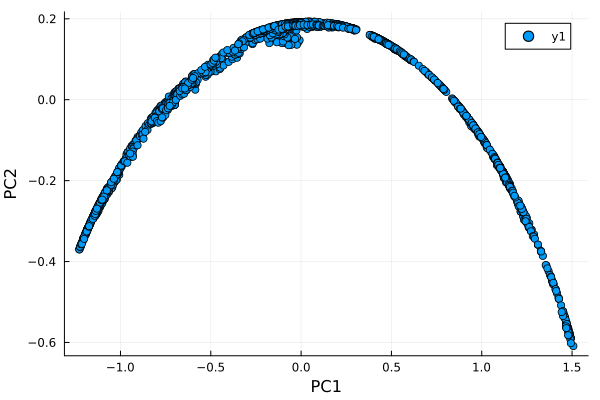

In [81]:
scatter(stocks_transformed[1, :], stocks_transformed[2, :], xlabel="PC1", ylabel="PC2")

### use the row numbers to color each point

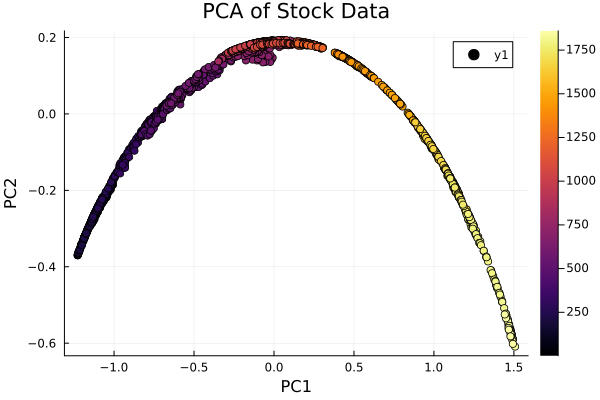

In [82]:
scatter( stocks_transformed[1, :], stocks_transformed[2, :], zcolor=row_numbers, 
        colorbar=true, xlabel="PC1", ylabel="PC2", title="PCA of Stock Data")

## Project the time series data onto 'Radial Plots'

- create the vector of angles by how much of a year has gone by in terms of market days
- then the radius of each radial plot is the projection onto a component

In [83]:
#market days
const market_days = 252
angles = row_numbers .* (2pi / market_days);

In [84]:
radii_1 = stocks_transformed[1, :];
radii_2 = stocks_transformed[2, :];

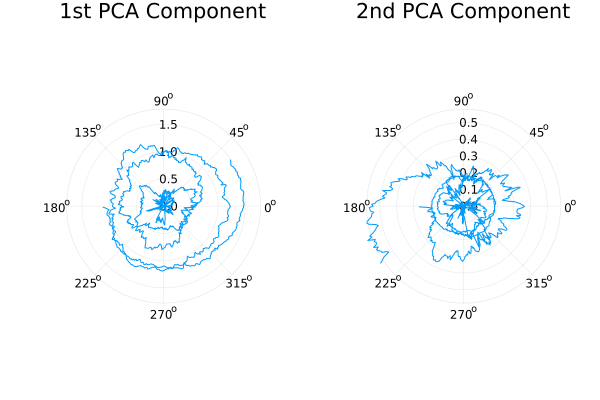

In [88]:
p1 = plot(angles, radii_1, title="1st PCA Component", legend=false, proj = :polar, margin=8mm )
p2 = plot(angles, radii_2, title="2nd PCA Component", legend=false, proj = :polar,  lims=(0,maximum(radii_2) .* 3 ), margin=8mm )
plot(p1,p2, layout=grid(1,2))

### now add month labels around the perimeter

- using a phasor to get the real and imaginary component from the rotation according to the angle

In [89]:
custom_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"];
angles_for_labels = collect( range(0, stop=2π, length=length(custom_labels) ) )
z = 1.15*exp.(im*2π*(0:length(custom_labels)-1)/length(custom_labels))

12-element Vector{ComplexF64}:
                   1.15 + 0.0im
     0.9959292143521045 + 0.5749999999999998im
     0.5750000000000001 + 0.9959292143521044im
   7.04171909509728e-17 + 1.15im
    -0.5749999999999997 + 0.9959292143521045im
    -0.9959292143521041 + 0.5750000000000003im
                  -1.15 + 1.408343819019456e-16im
    -0.9959292143521046 - 0.5749999999999996im
    -0.5750000000000005 - 0.9959292143521041im
 -2.112515728529184e-16 - 1.15im
     0.5749999999999992 - 0.9959292143521048im
      0.995929214352104 - 0.5750000000000005im

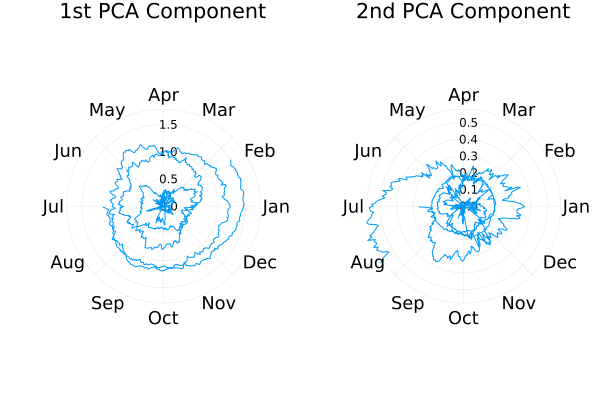

In [90]:
using Measures

p1 = plot( angles, radii_1, title="1st PCA Component", proj=:polar, xaxis=false, margin=8mm , legend=false )
annotate!(real.(z), imag.(z), text.(custom_labels,12))

p2 = plot(angles, radii_2, title="2nd PCA Component", legend=false, proj = :polar, margin=8mm , xaxis=false, lims=(0,maximum(radii_2) .* 3 ) )
annotate!(real.(z), imag.(z), text.(custom_labels,12))

plot( p1, p2, layout = grid(1,2) )